In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import pickle
import spacy 
nlp = spacy.load('en_core_web_sm')

In [2]:
# Use GPU if available
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# Load dataset

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dirpath = "drive/MyDrive/Holmusk/"
dataset = pd.read_csv(dirpath+"ClinNotes.csv")
dataset

,category,notes
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size...."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc..."
...,...,...
813,Cardiovascular / Pulmonary,"INDICATION: , Chest pain.,TYPE OF TEST: , Aden..."
814,Cardiovascular / Pulmonary,"CHIEF COMPLAINT: , Chest pain.,HISTORY OF PRES..."
815,Cardiovascular / Pulmonary,"HISTORY OF PRESENT ILLNESS: , The patient is a..."
816,Cardiovascular / Pulmonary,"HISTORY OF PRESENT ILLNESS: , Mr. ABC is a 60-..."


We will drop the 'category' column and parse the 'notes' column as our domain-specific text corpus.

In [5]:
# We do some simple text pre-processing, by lowercasing followed by tokenizing our text corpus.
tokens = []

for doc in nlp.pipe(dataset['notes'].str.lower().astype('unicode').values, batch_size=50,
                        n_process=3):
    if doc.is_parsed:
        tokens.append([n.text for n in doc])

    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)

<ipython-input-5-792d701ca6a5>:6: DeprecationWarning: [W107] The property `Doc.is_parsed` is deprecated. Use `Doc.has_annotation("DEP")` instead.
  if doc.is_parsed:


Our corpus is in the format of a list of lists, where each inner list represents a clinical document (total 818 documents). Let's see an example of what our processed corpus looks like.

In [6]:
tokens[0][:20] # First 20 tokens of the first document

['2',
 '-',
 'd',
 'm',
 '-',
 'mode',
 ':',
 ',',
 ',',
 '1',
 '.',
 ' ',
 'left',
 'atrial',
 'enlargement',
 'with',
 'left',
 'atrial',
 'diameter',
 'of']

In [7]:
# Need to reduce size of corpus because we are running out of RAM, so we keep only the alphabets and remove everything else.
out = []
for document_level in tokens:
  temp = []
  for token in document_level:
    if not token.isalpha():
      continue
    temp.append(token)
  out.append(temp)
print(out[0][:20])

['d', 'm', 'mode', 'left', 'atrial', 'enlargement', 'with', 'left', 'atrial', 'diameter', 'of', 'cm', 'normal', 'size', 'right', 'and', 'left', 'ventricle', 'normal', 'lv']


In [8]:
# Alright this looks better.
tokens = out

# 1. Word2Vec (trained from scratch)
Inspiration and some of the code taken from: https://towardsdatascience.com/a-word2vec-implementation-using-numpy-and-python-d256cf0e5f28

In [ ]:
def generate_dictionary_data(text):
    word_to_index= dict()
    index_to_word = dict()
    corpus = []
    count = 0
    vocab_size = 0
    
    for row in text:
        for word in row:
            # word = word.lower() # We did this already
            corpus.append(word)
            if word_to_index.get(word) == None:
                word_to_index.update ( {word : count})
                index_to_word.update ( {count : word })
                count  += 1
    vocab_size = len(word_to_index)
    length_of_corpus = len(corpus)
    
    return word_to_index,index_to_word,corpus,vocab_size,length_of_corpus

word_to_index, index_to_word, corpus, vocab_size, length_of_corpus = generate_dictionary_data(tokens)

In [ ]:
print(f"Vocab size={vocab_size}, length of corpus={length_of_corpus}")

Vocab size=12441, length of corpus=340771


The above code returns the following:
- word_to_index: a dictionary that associates a given word with a unique index
- index_to_word: the reverse mapping
- corpus: now our original list of lists has been compressed into a single large list. This is ok for word2vec, but we should think of sentence-level separation for ELMO and clinicalBERT.
- vocab size and length of corpus: Some statistics to tell us how big they are.

In [ ]:
def get_one_hot_vectors(target_word,context_words,vocab_size,word_to_index):
    
    #Create an array of size = vocab_size filled with zeros
    trgt_word_vector = np.zeros(vocab_size)
    
    #Get the index of the target_word according to the dictionary word_to_index. 
    #If target_word = best, the index according to the dictionary word_to_index is 0. 
    #So the one hot vector will be [1, 0, 0, 0, 0, 0, 0, 0, 0]
    index_of_word_dictionary = word_to_index.get(target_word) 
    
    #Set the index to 1
    trgt_word_vector[index_of_word_dictionary] = 1
    
    #Repeat same steps for context_words but in a loop
    ctxt_word_vector = np.zeros(vocab_size)
    
    
    for word in context_words:
        index_of_word_dictionary = word_to_index.get(word) 
        ctxt_word_vector[index_of_word_dictionary] = 1
        
    return trgt_word_vector,ctxt_word_vector
def generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus):

    xtrain_list = []
    ytrain_list = []
    for i,word in enumerate(corpus):

        index_target_word = i
        target_word = word
        context_words = []

        #when target word is the first word
        if i == 0:  

            # trgt_word_index:(0), ctxt_word_index:(1,2)
            context_words = [corpus[x] for x in range(i + 1 , window_size + 1)] 


        #when target word is the last word
        elif i == len(corpus)-1:

            # trgt_word_index:(9), ctxt_word_index:(8,7), length_of_corpus = 10
            context_words = [corpus[x] for x in range(length_of_corpus - 2 ,length_of_corpus -2 - window_size  , -1 )]

        #When target word is the middle word
        else:

            #Before the middle target word
            before_target_word_index = index_target_word - 1
            for x in range(before_target_word_index, before_target_word_index - window_size , -1):
                if x >=0:
                    context_words.extend([corpus[x]])

            #After the middle target word
            after_target_word_index = index_target_word + 1
            for x in range(after_target_word_index, after_target_word_index + window_size):
                if x < len(corpus):
                    context_words.extend([corpus[x]])


        trgt_word_vector,ctxt_word_vector = get_one_hot_vectors(target_word,context_words,vocab_size,word_to_index)
        #training_data.append([trgt_word_vector,ctxt_word_vector])   
        xtrain_list.append(trgt_word_vector)
        ytrain_list.append(ctxt_word_vector)
        
        
    return xtrain_list, ytrain_list

In [ ]:
# Even with reduced corpus, we are still running out of RAM. We subsample the corpus from 300K to 10K to show proof-of-concept. Note that word2vec needs full training data to run properly, also is sensitive to parameter settings.
xtrain, ytrain = generate_training_data(corpus=corpus[:10000],window_size=5,vocab_size=vocab_size,word_to_index=word_to_index,length_of_corpus=10000)

In [ ]:
# Next we code out a simple MLP to predict context one-hot vector given target one-hot vector (i.e. the skipgram method)
class MLP(torch.nn.Module):
    def __init__(self,
                 input_len,
                 hidden_size):
        super(MLP, self).__init__()

        self.fc1 = torch.nn.Linear(input_len, hidden_size)

        self.ReLU = torch.nn.ReLU()

        self.Dropout = torch.nn.Dropout(0.3)

        self.fc2 = torch.nn.Linear(hidden_size, input_len)

        self.Sigmoid = torch.nn.Sigmoid()

        self.init_parameters_He()

    def forward(self, x):

        out = self.fc1(x)

        out = self.ReLU(out)

        out = self.Dropout(out)

        out = self.fc2(out)

        out = self.Sigmoid(out)

        return out

    def init_parameters_He(self):

        torch.nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in')
        torch.nn.init.constant_(self.fc1.bias, 0.0)
        torch.nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in')
        torch.nn.init.constant_(self.fc2.bias, 0.0)

In [ ]:
# Some helper functions
class Dataset(torch.utils.data.Dataset):
    def __init__(self, feature, label):

        self.feature = feature

        self.label = label

    def __getitem__(self, index):
        
        return self.feature[index], self.label[index]

    def __len__(self):

        return len(self.feature)
def get_data(x, y, batch_size, shuffle=True):
    
    data = Dataset(torch.Tensor(x), torch.Tensor(y))
    loader = DataLoader(data, batch_size=batch_size, shuffle=shuffle)

    return loader
def train_word2vec(model, train_loader):
    model.train()
    total_loss = 0

    for step, (x, y) in enumerate(train_loader):

        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        BCELoss = torch.nn.BCEWithLogitsLoss()
        loss = BCELoss(output, y)
        total_loss += loss

        loss.backward()

        optimizer.step()
    return total_loss

In [ ]:
# Set some hyperparameters
LEARNING_RATE = 1e-3
HIDDEN_SIZE = 256
INPUT_LEN = vocab_size # The number of dimensions is the vocab size since 1-hot encoded.
NUM_EPOCHS = 100
BATCH_SIZE = 512

In [ ]:
# We will train this with the subsampled text corpus
train_loader = get_data(xtrain, ytrain, batch_size=BATCH_SIZE)

network = MLP(input_len=INPUT_LEN, hidden_size=HIDDEN_SIZE).to(device)
optimizer = torch.optim.Adam(network.parameters(), lr=LEARNING_RATE)

for epoch in range(1, NUM_EPOCHS + 1):
    print("We are at epoch %s" %epoch)
    loss = train_word2vec(network, train_loader)
    if epoch % 10 == 0:
      print(f"Epoch: {epoch}, Training loss is {loss}")

<ipython-input-14-d570cb0ce0f2>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  data = Dataset(torch.Tensor(x), torch.Tensor(y))


We are at epoch 1
We are at epoch 2
We are at epoch 3
We are at epoch 4
We are at epoch 5
We are at epoch 6
We are at epoch 7
We are at epoch 8
We are at epoch 9
We are at epoch 10
Epoch: 10, Training loss is 13.912400245666504
We are at epoch 11
We are at epoch 12
We are at epoch 13
We are at epoch 14
We are at epoch 15
We are at epoch 16
We are at epoch 17
We are at epoch 18
We are at epoch 19
We are at epoch 20
Epoch: 20, Training loss is 13.875393867492676
We are at epoch 21
We are at epoch 22
We are at epoch 23
We are at epoch 24
We are at epoch 25
We are at epoch 26
We are at epoch 27
We are at epoch 28
We are at epoch 29
We are at epoch 30
Epoch: 30, Training loss is 13.868687629699707
We are at epoch 31
We are at epoch 32
We are at epoch 33
We are at epoch 34
We are at epoch 35
We are at epoch 36
We are at epoch 37
We are at epoch 38
We are at epoch 39
We are at epoch 40
Epoch: 40, Training loss is 13.866289138793945
We are at epoch 41
We are at epoch 42
We are at epoch 43
We a

In [ ]:
# We should ideally train for much longer. However we stop here for now.
# Retrieve trained word embeddings. That will be the feature output from the 1st hidden layer
def extract_features(model, loader):
    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()
        return hook

    feature_list = []
    features = {}
    
    model.fc1.register_forward_hook(get_features('feats'))
    
    for step, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)

        output = model(x)

        feature_list.append(features['feats'].cpu().numpy())
    return np.vstack(feature_list)

In [ ]:
train_loader = get_data(xtrain, ytrain, batch_size=BATCH_SIZE, shuffle=False)
trained_word_embeddings = extract_features(network, train_loader)

In [ ]:
trained_word_embeddings.shape

(10000, 256)

In [ ]:
# We save this set of embeddings
pickle_out = open("/content/drive/MyDrive/Holmusk/word2vec_fromscratch.pickle", "wb")
pickle.dump(trained_word_embeddings, pickle_out)
pickle_out.close()

# 2. Evaluation
We will use the relations from MedicalConcepts.csv file to evaluate the quality of our learnt embeddings. The idea is that similarity between related words should be higher than similarity between word pairs that are randomly sampled.

In [ ]:
dirpath = "drive/MyDrive/Holmusk/"
df = pd.read_csv(dirpath+"MedicalConcepts.csv")
df

,Term1,Term2
0,Glaucoma,Fibrillation
1,Carbatrol,Dilantin
2,Cardiomyopathy,Tylenol
3,Herpes,Hyperthyroidism
4,Seasickness,Nausea
...,...,...
561,Meningism,Zovirax
562,Abortions.spontaneous,Listeriosis
563,Dyspnea,Agitation
564,Encephalitis,Headache


Process the medical concept pairs. We shall lowercase everything and if it's not found in our vocab, we will drop the pair.
We can only evaluate based on the embeddings in the subsampled corpus. Thus, the work is as follows. For each concept pair: 
- Lowercase and take only alphabets
- Query with our subsampled corpus, and check whether it has a corresponding learnt word embedding. If yes, output. Both words of each pair must have a word embedding, if not, drop
- For each word, calculate the correlation.
- For each pair, randomly sample a word from the corpus, and calculate the correlation.
- We expect that the correlation of the medical concept pairs should be on average, higher than that of random words.

In [ ]:
# First we load back the pickled data
with open(dirpath+"word2vec_fromscratch.pickle", 'rb') as handle:
    trained_word_embeddings = pickle.load(handle)
#print(trained_word_embeddings.shape)
# Then we process the medical concept pairs
concept_pairs = df.values.tolist()
concept_pairs = [[word.lower() for word in pair] for pair in concept_pairs] # Task 1a: Lowercase everything

In [ ]:
# Task 1b: Keep only alphabets. To make this neater, if there's time, consider pushing all cleaning code into an overall function.
out = []
for document_level in concept_pairs:
  temp = []
  for token in document_level:
    if not token.isalpha():
      continue
    temp.append(token)
  out.append(temp)
print(out[0:10])
concept_pairs = out

[['glaucoma', 'fibrillation'], ['carbatrol', 'dilantin'], ['cardiomyopathy', 'tylenol'], ['herpes', 'hyperthyroidism'], ['seasickness', 'nausea'], ['coccidioidomycosis', 'histoplasmosis'], ['angina', 'plavix'], ['zofran'], ['seizures', 'insulin'], ['septicemia', 'dyspnea']]


In [ ]:
# Task 2: Query with subsampled corpus
subsampled_corpus = corpus[:10000]
out = []
for word_pair in concept_pairs:
  try:
    word1, word2 = word_pair
  except ValueError: # One of the words got dropped out due to cleaning in Task 1b.
    continue
  if word1 not in subsampled_corpus or word2 not in subsampled_corpus:
    continue
  out.append([word1, word2])
print(len(out))

23


In [ ]:
# That's very sad, we're only left with 23 word-pairs that also have trained word embeddings after we subsampled our corpus. Let's see what are they.
concept_pairs = out
concept_pairs

[['nausea', 'vomiting'],
 ['coumadin', 'aspirin'],
 ['epilepsy', 'alcohol'],
 ['dysuria', 'plavix'],
 ['hyperthyroidism', 'seizures'],
 ['hypothyroidism', 'weakness'],
 ['pain', 'morphine'],
 ['incontinence', 'lasix'],
 ['convulsion', 'epilepsy'],
 ['neuropathy', 'diabetes'],
 ['hypothyroidism', 'synthroid'],
 ['arthritis', 'cirrhosis'],
 ['syncope', 'weakness'],
 ['fibrillation', 'coumadin'],
 ['plavix', 'coumadin'],
 ['chills', 'snoring'],
 ['fibrillation', 'synthroid'],
 ['vasculitis', 'convulsion'],
 ['syncope', 'xanax'],
 ['tylenol', 'motrin'],
 ['diabetes', 'polyuria'],
 ['headache', 'tylenol'],
 ['hyperthyroidism', 'osteoporosis']]

In [ ]:
# Task 3: Calculate the correlation
def calculate_cosine_similarity(a, b):
  from numpy import dot
  from numpy.linalg import norm
  # Given 2 vectors a and b, calculate their cosine similarity
  cos_sim = dot(a, b)/(norm(a)*norm(b))
  return cos_sim

In [ ]:
concept_sims, random_sims = [], []
concept_embs = {}
for i, pair in enumerate(concept_pairs):
  w1, w2 = pair
  # Retrieve their embeddings. The output will be all locations that have this word. Since the same word will have the same embedding, we take the first instance.
  w1_ind = np.where(np.array(subsampled_corpus) == w1)[0][0] 
  w2_ind = np.where(np.array(subsampled_corpus) == w2)[0][0]
  w1_emb = trained_word_embeddings[w1_ind]
  w2_emb = trained_word_embeddings[w2_ind]
  # For each pair, pick a random word from the subsampled corpus and output the corresponding embedding
  np.random.seed(i)
  rand_ind = np.random.randint(0, len(subsampled_corpus))
  rand_emb = trained_word_embeddings[rand_ind]
  # Calculate cosine sim
  concept_cossim = calculate_cosine_similarity(w1_emb, w2_emb)
  random_cossim = calculate_cosine_similarity(w1_emb, rand_emb)
  concept_sims.append(concept_cossim)
  random_sims.append(random_cossim)
  # We output the embeddings also
  concept_embs[w1] = w1_emb
  concept_embs[w2] = w2_emb
  concept_embs[subsampled_corpus[rand_ind]] = rand_emb
concept_sims = np.array(concept_sims)
random_sims = np.array(random_sims)
print(f"Average cosine similarity of a concept pair is {np.mean(concept_sims):.3f} versus a random pair is {np.mean(random_sims):.3f}")

Average cosine similarity of a concept pair is 0.996 versus a random pair is 0.995


The similarity is very close and is probably not statistically significant. This has very much to do with:
1. We subsampled the corpus - did not see enough words
2. Amount of training - The network is very likely not trained for long enough. We could have increased number of epochs and done a whole bunch of architectural design and hyperparameter tuning. Also, negative sampling and hierarchical softmax will help with training.  

Thus, the trained word embeddings probably not of high quality. Nonetheless we can attempt to visualise them.

In [ ]:
def tsne_plot():
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word, emb in concept_embs.items():
        tokens.append(np.array(emb))
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(np.array(tokens))

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

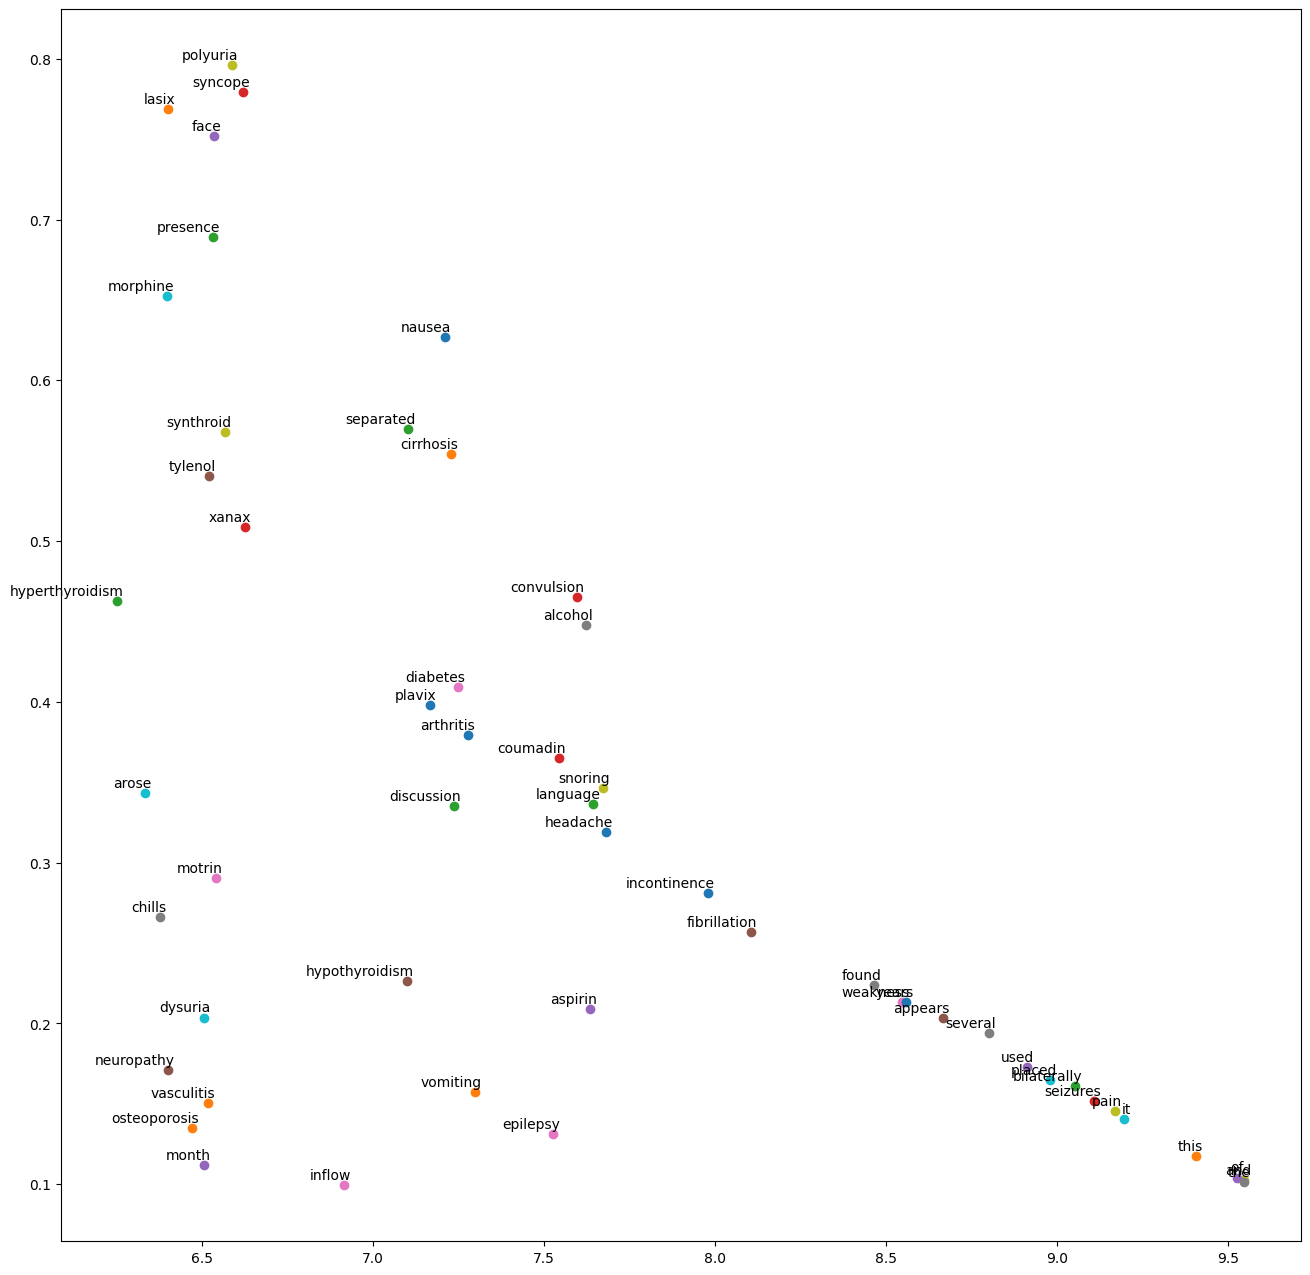

In [ ]:
tsne_plot() # Visualisations don't support the hypothesis that related word concepts should be close together, e.g. nausea and vomitting are far apart.

# 3. Using Gensim.
Gensim has inbuilt libraries for faster training (it says: The training is streamed, meaning sentences can be a generator, reading input data from disk on-the-fly, without loading the entire corpus into RAM), which will probably address our problem with not enough RAM. It is also intelligent enough to come up with suitable default hyperparameters.

In [10]:
from gensim.models import Word2Vec, KeyedVectors

In [ ]:
# Let us use back the list of lists from our original corpus, and we train a Word2Vec model
model = Word2Vec(
        tokens,
        vector_size=300,
        window=10,
        min_count=1,
        workers=10)

In [ ]:
dirpath = "drive/MyDrive/Holmusk/"
word_vectors = model.wv
word_vectors.save(dirpath+"word2vec_gensim.wordvectors")

In [12]:
# Load back the saved word_vectors
dirpath = "drive/MyDrive/Holmusk/"
wv = KeyedVectors.load(dirpath+"word2vec_gensim.wordvectors", mmap='r')
wv['nausea'].shape

(300,)

In [13]:
# It is so simple..! Why have I wasted so much time trying to code my own Word2Vec... 
# Now let's try again to see word similarity
w1 = 'nausea'
wv.most_similar(positive=w1) # Okay it works. Now let's go back to our original hypothesis where we evaluate based on concept pairs

[('vomiting', 0.9972293972969055),
 ('fevers', 0.9907978773117065),
 ('fatigue', 0.9894964694976807),
 ('cough', 0.9833284020423889),
 ('chills', 0.9807529449462891),
 ('fever', 0.9756684303283691),
 ('syncope', 0.9752371907234192),
 ('diaphoresis', 0.974254846572876),
 ('problems', 0.9733768701553345),
 ('pains', 0.9728589057922363)]

# 4. Evaluation method 1
The idea that related concepts have greater similarity compared to random word pairs.

In [14]:
# We get back the long concept-pair dataset first
dirpath = "drive/MyDrive/Holmusk/"
df = pd.read_csv(dirpath+"MedicalConcepts.csv")
concept_pairs = df.values.tolist()
concept_pairs = [[word.lower() for word in pair] for pair in concept_pairs] # Task 1a: Lowercase everything
# Task 1b: Keep only alphabets. To make this neater, if there's time, consider pushing all cleaning code into an overall function.
out = []
for document_level in concept_pairs:
  temp = []
  for token in document_level:
    if not token.isalpha():
      continue
    temp.append(token)
  out.append(temp)
print(out[0:10], len(out))
concept_pairs = out

[['glaucoma', 'fibrillation'], ['carbatrol', 'dilantin'], ['cardiomyopathy', 'tylenol'], ['herpes', 'hyperthyroidism'], ['seasickness', 'nausea'], ['coccidioidomycosis', 'histoplasmosis'], ['angina', 'plavix'], ['zofran'], ['seizures', 'insulin'], ['septicemia', 'dyspnea']] 566


In [15]:
# Still have to account for concept dropping out because of Task1b
out = []
for word_pair in concept_pairs:
  try:
    word1, word2 = word_pair
  except ValueError: # One of the words got dropped out due to cleaning in Task 1b.
    continue
  out.append([word1, word2])
print(len(out))
concept_pairs = out

535


In [16]:
# Lastly, let's flatten the list of lists
corpus = [token for sent in tokens for token in sent]

In [17]:
# Finding cosine similarity
def calculate_cosine_similarity(a, b):
  from numpy import dot
  from numpy.linalg import norm
  # Given 2 vectors a and b, calculate their cosine similarity
  cos_sim = dot(a, b)/(norm(a)*norm(b))
  return cos_sim

concept_sims, random_sims = [], []
concept_embs = {}
for i, pair in enumerate(concept_pairs):
  w1, w2 = pair
  # Retrieve their embeddings. The output will be all locations that have this word. Since the same word will have the same embedding, we take the first instance.
  try:
    w1_emb = wv[w1]
    w2_emb = wv[w2]
  except KeyError: # The concept not found in corpus
    continue
  # For each pair, pick a random word from the corpus ("tokens") and output the corresponding embedding
  np.random.seed(i)
  rand_ind = np.random.randint(0, len(corpus))
  rand_emb = wv[corpus[rand_ind]]
  # Calculate cosine sim
  concept_cossim = calculate_cosine_similarity(w1_emb, w2_emb)
  random_cossim = calculate_cosine_similarity(w1_emb, rand_emb)
  concept_sims.append(concept_cossim)
  random_sims.append(random_cossim)
  # We output the embeddings also
  concept_embs[w1] = w1_emb
  concept_embs[w2] = w2_emb
  #concept_embs[corpus[rand_ind]] = rand_emb
concept_sims = np.array(concept_sims)
random_sims = np.array(random_sims)
print(f"Average cosine similarity of a concept pair is {np.mean(concept_sims):.3f} versus a random pair is {np.mean(random_sims):.3f}")

Average cosine similarity of a concept pair is 0.685 versus a random pair is 0.404


Nice! This support our hypothesis that a related concept pair should be more similar in embedding space, than a random pair of words.

Next we attempt a visualisation.

In [21]:
vocab = wv.key_to_index.keys()
labels = []
tokens = []
for word in vocab:
  # Get embedding
  emb = wv[word]
  tokens.append(emb)
  labels.append(word)

In [ ]:
from sklearn.manifold import TSNE

# Do tsne
tsne_model = TSNE(perplexity=15, n_components=2, init='pca', n_iter=1000, random_state=23)
tsne_values = tsne_model.fit_transform(np.array(tokens))
# Save tsne values, because it takes a long time
with open(dirpath+'word2vec_gensim_tsne.pickle', 'wb') as handle:
    pickle.dump(tsne_values, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
# We load back the tsne values that we have calculated
with open(dirpath+'word2vec_gensim_tsne.pickle', 'rb') as handle:
    b = pickle.load(handle)
tsne_values = b
tsne_values.shape

(12441, 2)

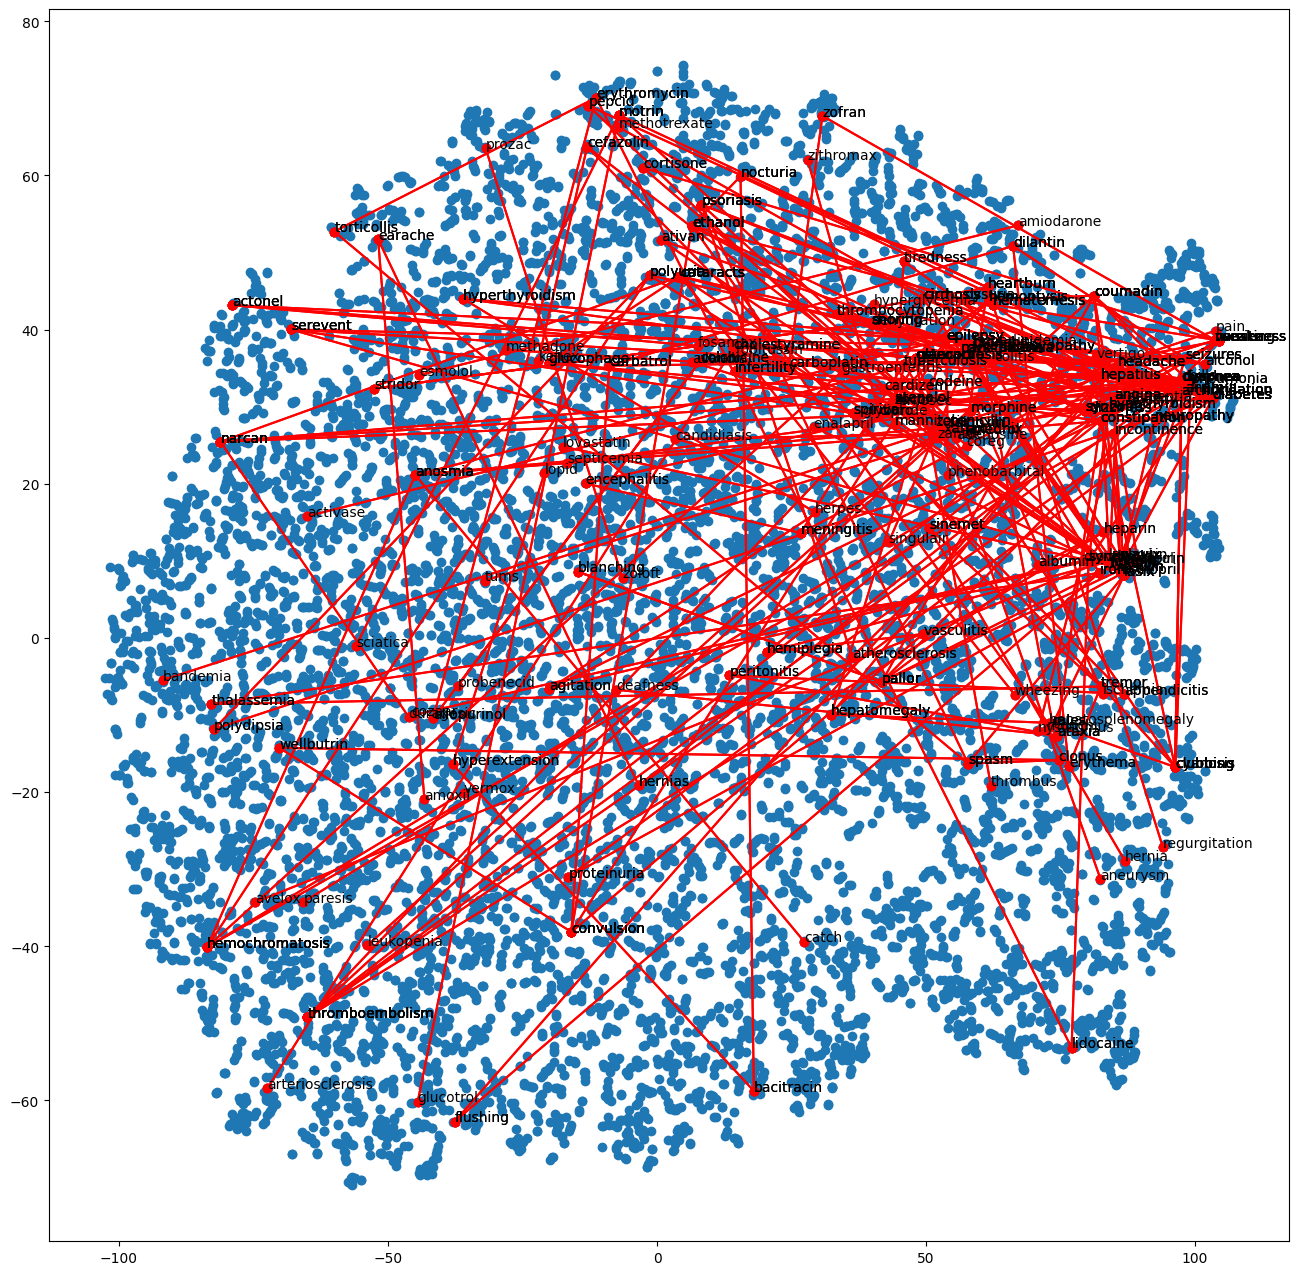

In [29]:
import matplotlib.pyplot as plt
import itertools

x = []
y = []
for value in tsne_values:
    x.append(value[0])
    y.append(value[1])
    
plt.figure(figsize=(16, 16)) 
plt.scatter(tsne_values[:, 0], tsne_values[:, 1])
for i, label in enumerate(labels):
  # Find its word pair
  for pair in concept_pairs:
    if label in pair:
      ind = np.where(np.array(pair)==label)[0][0]
      paired_word = pair[1-ind]
      # Pull out label position of the paired word
      paired_ind = np.where(np.array(labels)==paired_word)[0]
      if len(paired_ind) == 0: # not in corpus
        continue
      newx = [x[i], x[paired_ind[0]]] 
      newy = [y[i], y[paired_ind[0]]]
      plt.scatter(newx, newy, color='r')
      plt.plot(newx, newy, color=next(colors))
      plt.annotate(label, xy=(x[i], y[i])) # Messy as lines criss-cross. Remove lines?

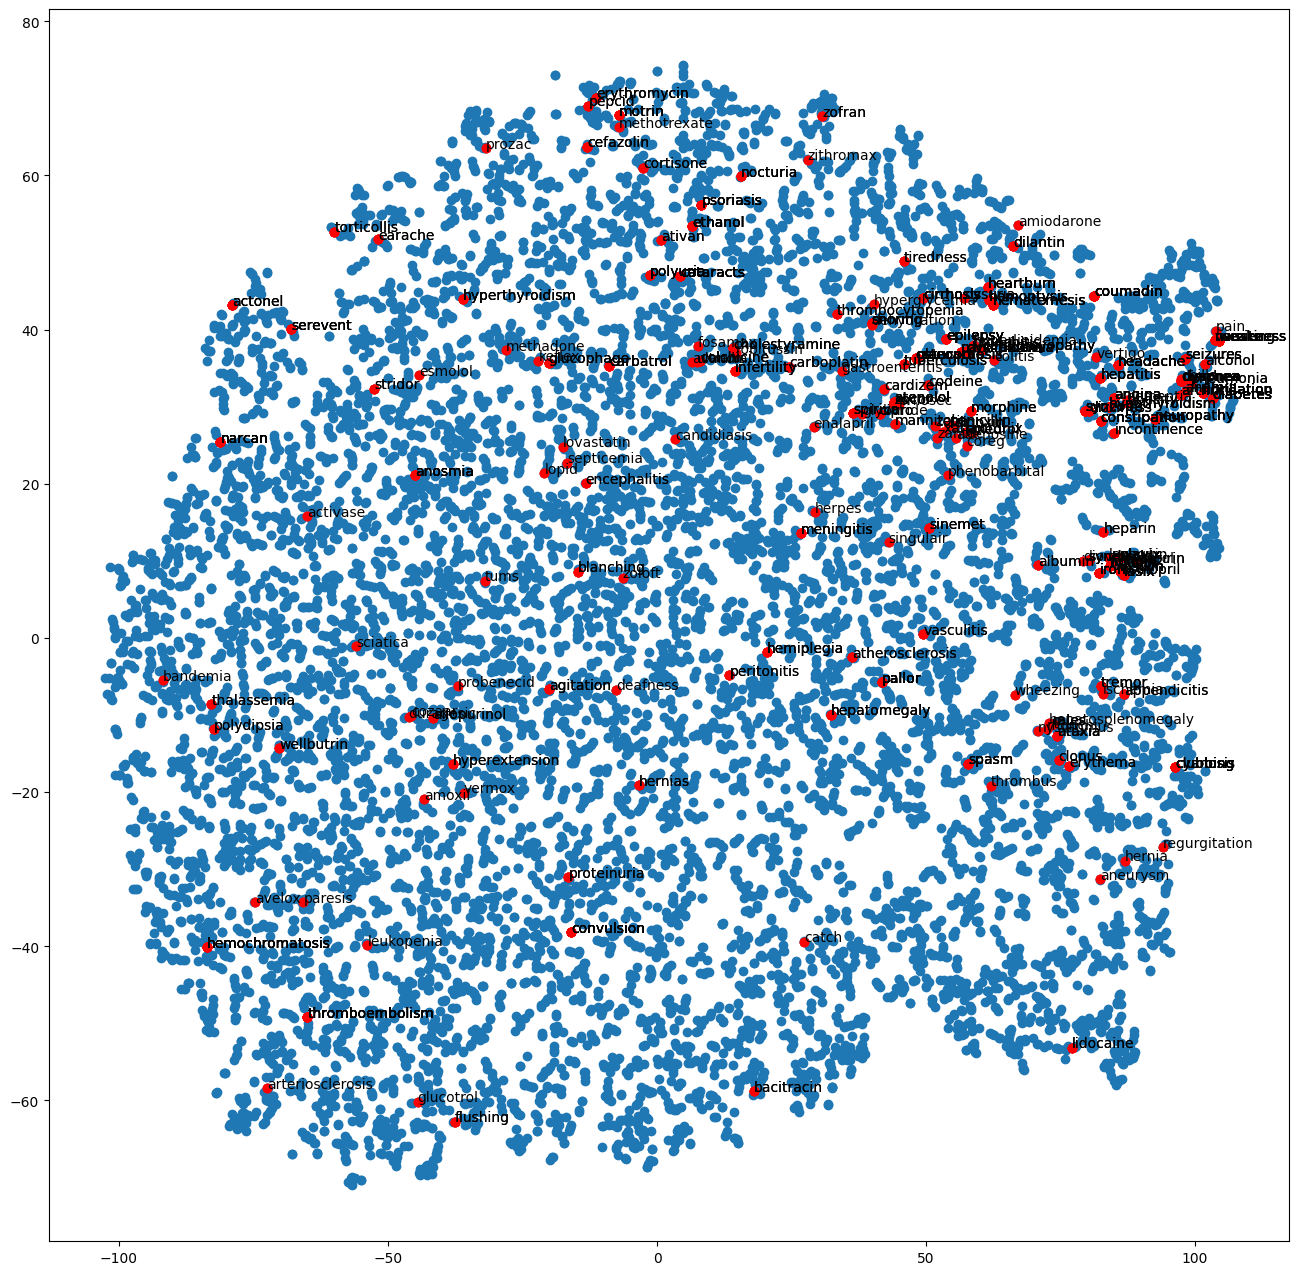

In [30]:
x = []
y = []
for value in tsne_values:
    x.append(value[0])
    y.append(value[1])
    
plt.figure(figsize=(16, 16)) 
plt.scatter(tsne_values[:, 0], tsne_values[:, 1])
for i, label in enumerate(labels):
  # Find its word pair
  for pair in concept_pairs:
    if label in pair:
      ind = np.where(np.array(pair)==label)[0][0]
      paired_word = pair[1-ind]
      # Pull out label position of the paired word
      paired_ind = np.where(np.array(labels)==paired_word)[0]
      if len(paired_ind) == 0:
        continue
      newx = [x[i], x[paired_ind[0]]]
      newy = [y[i], y[paired_ind[0]]]
      plt.scatter(newx, newy, color='r')
      #plt.plot(newx, newy, color=next(colors))
      plt.annotate(label, xy=(x[i], y[i]))

We conclude that visualising word pairs directly on a word cloud is not very effective. This could be due to:
- TSNE not flattening the data the way we want so it's not obvious
- The long distances overpower the short ones making it difficult to visualise.

Let us try to use clustering technique to create better visualisations.

# 5. Evaluation way 2
Evaluate the word embeddings based on clustering and topic modelling.

(This was actually done after I did the same for Notebook 2: ClinicalBERT embeddings, and I did this to make the analysis complete)

In [32]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install umap-learn
!pip install hdbscan
import umap
import hdbscan
import pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=168ee2b8927149b4502c2e7b02b23bf5bd6f2248fbd5efd7a2bfd38d926290ae
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=8d65b54564f8a68987c4942f3586ed8a00ee9e4ae6927048be34a4af6f8b066d
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/p

In [38]:
# My word embeddings are saved in "tokens" as a list
tokens = np.array(tokens)
# UMAP to reduce dimensions. We could have used TSNE also but just to keep things consistent.
reducer = umap.UMAP()
reducer.fit(tokens)
umap_vocab_emb = reducer.transform(tokens)
umap_vocab_emb.shape

(12441, 2)

In [39]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=80, min_samples=15, prediction_data=True)
clusterer.fit(umap_vocab_emb)

HDBSCAN(min_cluster_size=80, min_samples=15, prediction_data=True)

<Axes: ylabel='$\\lambda$ value'>

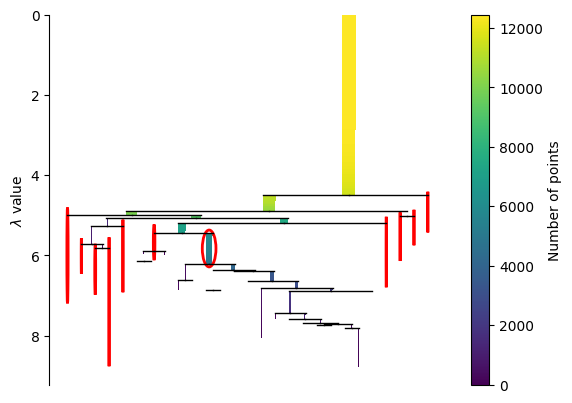

In [40]:
clusterer.condensed_tree_.plot(select_clusters=True)

In [42]:
# How many clusters do we have?
clusterer.labels_.max() # 11 clusters + 1 noise cluster

10

In [43]:
# Lastly, we implement c-TF-IDF, by calculating tf-idf per class, using code from https://www.pinecone.io/learn/bertopic/ as inspiration
classes = {label: {'tokens': []} for label in set(clusterer.labels_)}
for i, word in enumerate(vocab):
  label = clusterer.labels_[i]
  classes[label]['tokens'].append(word)

In [45]:
tf = np.zeros((len(classes.keys()), len(vocab)))

for c, _class in enumerate(classes.keys()):
    for t, term in enumerate(vocab):
        tf[c, t] = classes[_class]['tokens'].count(term)

In [46]:
idf = np.zeros((1, len(vocab)))

# calculate average number of words per class
A = tf.sum() / tf.shape[0]

for t, term in enumerate(vocab):
    # frequency of term t across all classes
    f_t = tf[:,t].sum()
    # calculate IDF
    idf_score = np.log(1 + (A / f_t))
    idf[0, t] = idf_score

In [53]:
vocab_list = list(vocab)
tf_idf = tf*idf # Our score is in num_classes * num_tokens in vocab
# For each class, we find the top n scores
n = 10
top_idx = np.argpartition(tf_idf, -n)[:, -n:]
# Lastly, we map this back to the words
for c, _class in enumerate(classes.keys()):
    topn_idx = top_idx[c, :]
    topn_terms = [vocab_list[idx] for idx in topn_idx]
    print(topn_terms) 
# Compared to ClinicalBERT where it is simply "clinical-term" vs "non-clinical-term", Now it's not so easy to identify topics from clusters as each cluster seem to have different meanings.
# Word Cloud visualisation may give us a better idea - later

['piece', 'xiphoid', 'properly', 'ethibond', 'ventriculostomy', 'accessed', 'spatulated', 'transluminal', 'begun', 'hypopharynx']
['identified', 'site', 'fashion', 'divided', 'sutures', 'visualization', 'incision', 'inferior', 'advanced', 'the']
['length', 'fossa', 'ligament', 'metzenbaum', 'umbilical', 'mesoappendix', 'cannulated', 'amounts', 'j', 'stitch']
['pains', 'consisted', 'performance', 'rapidly', 'ambulate', 'surgeries', 'somnolent', 'outlined', 'extremely', 'infusion']
['melanosis', 'attenuated', 'angiographically', 'mostly', 'retroflex', 'denervation', 'parenchyma', 'biopsied', 'span', 'ramus']
['lortab', 'ifat', 'bridge', 'bph', 'bicarb', 'decadron', 'unspecified', 'therapeutic', 'puffs', 'employed']
['balance', 'apnea', 'abc', 'return', 'anxiety', 'alternatives', 'workup', 'physical', 'ray', 'plavix']
['culture', 'node', 'rectal', 'septum', 'intracranial', 'pupils', 'neural', 'sec', 'oral', 'gadolinium']
['etoh', 'type', 'exercise', 'him', 'frequent', 'weakness', 'needed'

In [59]:
# We first come back to our hypothesis that related clinical terms are more likely to be in the same cluster, than non-related clinical terms.
# We get embeddings first
p1_out = []
p2_out = []
for p1,p2 in concept_pairs:
  try:
    p1_emb = wv[p1]
    p2_emb = wv[p2]
  except KeyError: # concept not in corpus
    continue
  p1_out.append(p1_emb)
  p2_out.append(p2_emb)
p1_out = np.vstack(p1_out)
p2_out = np.vstack(p2_out)
print(p1_out.shape, p2_out.shape)


(255, 300) (255, 300)


In [60]:
# Then we get the predicted cluster labels
umap_p1 = reducer.transform(p1_out)
umap_p2 = reducer.transform(p2_out)
p1_label, strengths = hdbscan.approximate_predict(clusterer, umap_p1)
p2_label, strengths = hdbscan.approximate_predict(clusterer, umap_p2)

In [61]:
# Then we find the proportions of times the concept pairs are assigned to same cluster, versus when they are not
total_count = 0
same_count = 0
for p1, p2 in zip(p1_label, p2_label):
  if p1 == -1 or p2 == -1: continue
  if p1 == p2:
    same_count += 1
  total_count += 1
same_prop = same_count / total_count
print(f"{same_prop:3f} of concept-pairs have been assigned to the same cluster!") 

0.170068 of concept-pairs have been assigned to the same cluster!


In [64]:
#Interestingly, most of the time, they are in different cluster.
# Let's see roughly where they appear
from collections import defaultdict
countdict = defaultdict(int)
for i, (p1, p2) in enumerate(zip(p1_label, p2_label)):
  if p1 == -1 or p2 == -1: continue
  countdict[p1] += 1
  countdict[p2] += 1
countdict

defaultdict(int, {3: 58, 8: 45, 10: 91, 6: 55, 9: 16, 7: 11, 5: 15, 4: 3})

In [65]:
# Most of the time, they appear in clusters 3, 6, 8 and 10. Let's see what's the WordCloud like.
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
# For each class, get the words
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def plot_word_cloud(class_label):
  words = classes[class_label]['tokens']
  words = [w.lower() for w in words] # Lowercase
  comment_words = " ".join(words)
  stopwords = set(STOPWORDS)
  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

  # plot the WordCloud image                      
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.show()


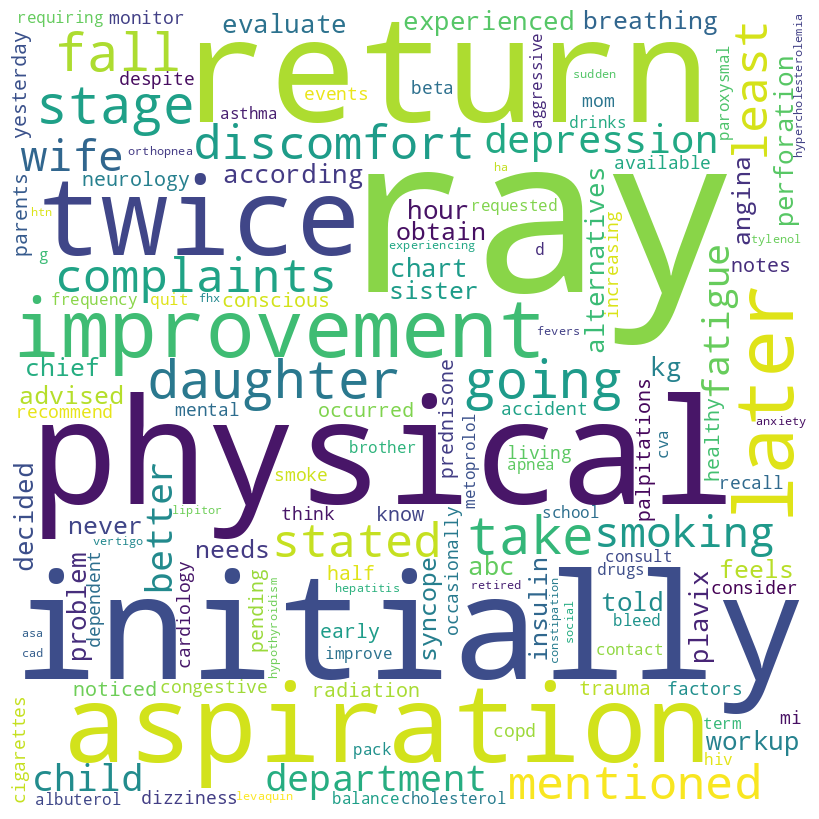

In [68]:
plot_word_cloud(6) # This could be symptoms as well similar to Cloud 8, but maybe less laden with clinical meaning. 

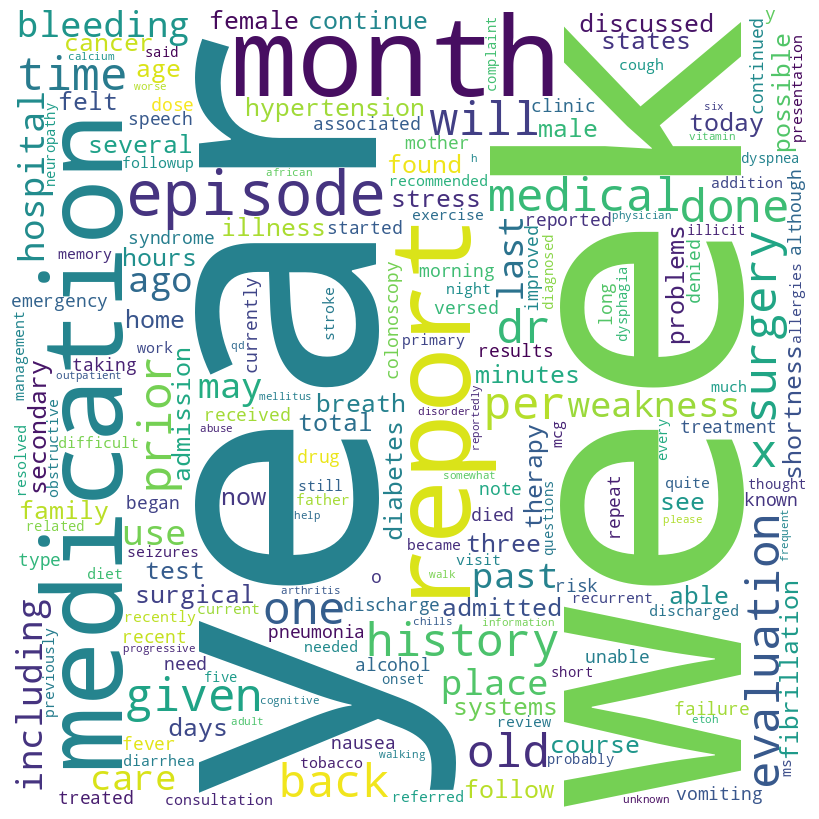

In [69]:
plot_word_cloud(8) # This one looks like procedures and symptoms.

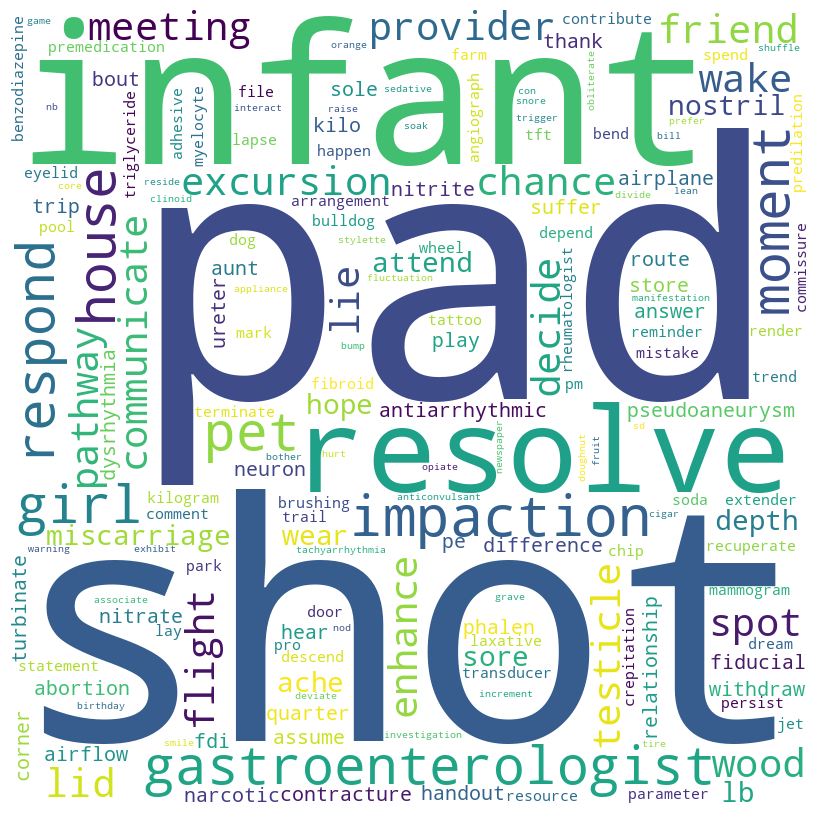

In [70]:
plot_word_cloud(10) # This is probably where most of the medical terms come under, e.g. clinical ways of calling a particular disease.

Compared to the ClinicalBERT model, the word embeddings are "more easily spread out" and thus we get more clusters with more granulated meaning. This is likely due to two things:
- The vocab of the ClinicalBERT model is larger and consist of a lot of things other than what we have in our Medical Concepts and our text corpus.
- To get the vocab embeddings to build the word cloud, we pre-processed the vocab in Word2Vec to get only text, but we did not do this in ClinicalBERT. (Although I think that even if we have done it, the embedding space will still be more similar than different)